## Problem

A critical valve in a steam plant may be in one of two states: normal or broken.  The state of the valve changes over time according to Markovian dynamics (the next state only depends on the previous state).  The initial valve state is normal.  If the current valve state is broken, the next valve state must be broken.  If the current valve state is normal, the next valve state has a 0.2 probability of becoming broken.  We model the valve state over 3 consecutive time steps (i.e., first time step, second time step, third time step).

Note: This is not a continuous time model and we do not care about the exact times.  We simply have 3 different discrete random variables for valve state corresponding to the valve state at 3 consecutive time steps.

A very noisy sensor monitors the valve state at every time step.  The sensor may take on one of two assignments: observed_normal or observed_broken.  If the valve state is normal, there is a uniform (i.e., equal) probability of the sensor reading either observed_normal or observed_broken.  If the valve state is broken, then the sensor will always read observed_broken.

Answer the following questions, by showing the code that executes the query and produces the exact numerical result:

1. Given no evidence, what is the probability that the valve state is broken at the third time step?
2. Given the evidence observed_broken for the sensor at the second time step, what is the probability that the valve state is broken at the third time step?
3. Given the sensor observation sequence (observed_broken, observed_normal, observed_broken) as evidence, what is the probability that the valve state is broken at the third time step?
4. Given the sensor observation sequence (observed_broken, observed_broken, observed_broken) as evidence, what is the probability that the valve state is broken at the third time step?
5. Given the evidence that the valve state at the second time step is normal, what is the probability of observing sensor value observed_normal at the third time step?


In [1]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD as cpd
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
import pandas as pd
import numpy as np
from BayesNet import BayesNet
from TabularCPD import TabularCPD as cpd_my
from variable_elimination import VariableElimination as VariableElimination_my
from gibbs_sampler import Gibbs_Sampler
import matplotlib.pyplot as plt
from copy import *

In [2]:
valve = BayesianModel([('v1', 'v2'), 
                       ('v2', 'v3'),
                       ('v1', 's1'),
                       ('v2', 's2'),
                       ('v3', 's3')])

v_v_values = [[1, 0.2], [0, 0.8]]
v_s_values = [[1, 0.5], [0, 0.5]]

cpd_v1 = cpd(variable='v1', variable_card=2,values=[[0], [1]])
cpd_v2 = cpd(variable='v2', variable_card=2,
            values=v_v_values,
            evidence=['v1'],
            evidence_card=[2])
cpd_v3 = cpd(variable='v3', variable_card=2,
            values=v_v_values,
            evidence=['v2'],
            evidence_card=[2])
cpd_s1 = cpd(variable='s1', variable_card=2,
            values=v_s_values,
            evidence=['v1'],
            evidence_card=[2])
cpd_s2 = cpd(variable='s2', variable_card=2,
            values=v_s_values,
            evidence=['v2'],
            evidence_card=[2])
cpd_s3 = cpd(variable='s3', variable_card=2,
            values=v_s_values,
            evidence=['v3'],
            evidence_card=[2])


In [3]:
valve.add_cpds(cpd_v1, cpd_v2, cpd_v3, cpd_s1, cpd_s2, cpd_s3)

In [4]:
valve_my = BayesNet([('v1', 'v2'), 
                       ('v2', 'v3'),
                       ('v1', 's1'),
                       ('v2', 's2'),
                       ('v3', 's3')])
v_v_values = [[1, 0.2], [0, 0.8]]
v_s_values = [[1, 0.5], [0, 0.5]]

cpd_v1_my = cpd_my(variable='v1', values=[[0], [1]])
cpd_v2_my = cpd_my(variable='v2',
            values=v_v_values,
            evidence=['v1'])
cpd_v3_my = cpd_my(variable='v3',
            values=v_v_values,
            evidence=['v2'])
cpd_s1_my = cpd_my(variable='s1',
            values=v_s_values,
            evidence=['v1'])
cpd_s2_my = cpd_my(variable='s2', 
            values=v_s_values,
            evidence=['v2'])
cpd_s3_my = cpd_my(variable='s3', 
            values=v_s_values,
            evidence=['v3'])

In [5]:
valve_my.add_cpds([cpd_v1_my, cpd_v2_my, cpd_v3_my, cpd_s1_my, cpd_s2_my, cpd_s3_my])

In [6]:
def plot_it(final, steps, val_0, val_1):
    plt.axhline(y=final[0], color='r', linestyle=':', label='0 exact')
    plt.axhline(y=final[1], color='r', linestyle=':', label='1 exact')
    plt.plot(steps, val_0, label='0 sample')
    plt.plot(steps, val_1, label='1 sample')
    plt.legend(loc='best')
    plt.show()

## Run queries

### 1. Given no evidence, what is the probability that the valve state is broken at the third time step?

Answer: 0.36

In [7]:
valve_my.add_cpds([cpd_v1_my, cpd_v2_my, cpd_v3_my, cpd_s1_my, cpd_s2_my, cpd_s3_my])
sampler = Gibbs_Sampler(valve_my)
sample_data = sampler.query(['v3'], 5000, 1000, 50)
steps_q1 = sample_data['v3'][1]['steps']
val_0_q1 = sample_data['v3'][1]['0_val']
val_1_q1 = sample_data['v3'][1]['1_val']
final_q1 = sample_data['v3'][0]

In [8]:
valve_my.add_cpds([cpd_v1_my, cpd_v2_my, cpd_v3_my, cpd_s1_my, cpd_s2_my, cpd_s3_my])
infer_my = VariableElimination_my(valve_my)
q1_my = infer_my.query(['v3'])
print(q1_my['v3'])
exact_q1 = q1_my['v3'].prob[:,-1].tolist()

Nodes: ['v3']
Probabilities:
[[0.   0.36]
 [1.   0.64]]



{0: 0.6472, 1: 0.3526}


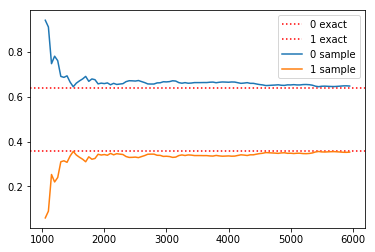

In [9]:
print(final_q1)
plot_it(exact_q1, steps_q1, val_0_q1, val_1_q1)

In [10]:
infer = VariableElimination(valve)
q1 = infer.query(variables=['v3'])
print(q1['v3'])

╒══════╤═══════════╕
│ v3   │   phi(v3) │
╞══════╪═══════════╡
│ v3_0 │    0.3600 │
├──────┼───────────┤
│ v3_1 │    0.6400 │
╘══════╧═══════════╛


After 2000 steps, the sampler appears to asymptote the exact solution

### 2. Given the evidence observed_broken for the sensor at the second time step, what is the probability that the valve state is broken at the third time step?

Answer: 0.4667

In [25]:
valve_my.add_cpds([cpd_v1_my, cpd_v2_my, cpd_v3_my, cpd_s1_my, cpd_s2_my, cpd_s3_my])
sampler = Gibbs_Sampler(valve_my)
sample_data = sampler.query(['v3'], 10000, 2000, 50,evidence={'s2':0})
steps_q2 = sample_data['v3'][1]['steps']
val_0_q2 = sample_data['v3'][1]['0_val']
val_1_q2 = sample_data['v3'][1]['1_val']
final_q2 = sample_data['v3'][0]

In [26]:
q2_my = infer_my.query(['v3'], evidence={'s2':0})
print(q2_my['v3'])
exact_q2 = q2_my['v3'].prob[:,-1].tolist()

Nodes: ['v3']
Probabilities:
[[0.         0.46666667]
 [1.         0.53333333]]



{0: 0.5368, 1: 0.4631}


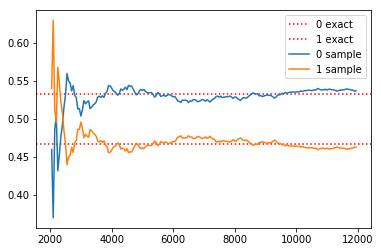

In [27]:
print(final_q2)
plot_it(exact_q2, steps_q2, val_0_q2, val_1_q2)

In [14]:
q2 = infer.query(variables=['v3'], evidence={'s2':0})
print(q2['v3'])

╒══════╤═══════════╕
│ v3   │   phi(v3) │
╞══════╪═══════════╡
│ v3_0 │    0.4667 │
├──────┼───────────┤
│ v3_1 │    0.5333 │
╘══════╧═══════════╛


After 4000 steps, the sampler appears to asymptote the exact solution

### 3. Given the sensor observation sequence (observed_broken, observed_normal, observed_broken) as evidence, what is the probability that the valve state is broken at the third time step?

Answer: 0.333

In [15]:
valve_my.add_cpds([cpd_v1_my, cpd_v2_my, cpd_v3_my, cpd_s1_my, cpd_s2_my, cpd_s3_my])
sampler = Gibbs_Sampler(valve_my)
sample_data = sampler.query(['v3'], 5000, 1000, 50, evidence={'s1':0, 's2':1, 's3':0})
steps_q3 = sample_data['v3'][1]['steps']
val_0_q3 = sample_data['v3'][1]['0_val']
val_1_q3 = sample_data['v3'][1]['1_val']
final_q3 = sample_data['v3'][0]

In [16]:
q3_my = infer_my.query(['v3'], evidence={'s1':0, 's2':1, 's3':0})
print(q3_my['v3'])
exact_q3 = q3_my['v3'].prob[:,-1].tolist()

Nodes: ['v3']
Probabilities:
[[0.         0.33333333]
 [1.         0.66666667]]



{0: 0.669, 1: 0.3308}


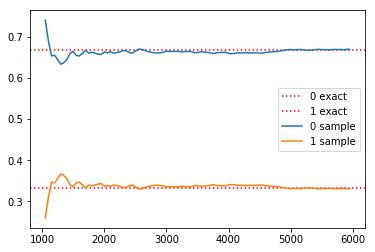

In [17]:
print(final_q3)
plot_it(exact_q3, steps_q3, val_0_q3, val_1_q3)

In [18]:
q3 = infer.query(variables=['v3'], evidence={'s1':0, 's2':1, 's3':0})
print(q3['v3'])

╒══════╤═══════════╕
│ v3   │   phi(v3) │
╞══════╪═══════════╡
│ v3_0 │    0.3333 │
├──────┼───────────┤
│ v3_1 │    0.6667 │
╘══════╧═══════════╛


After 1500 steps, the sampler appears to asymptote the exact solution